In [3]:
import pandas as pd

df = pd.read_csv("US_Accidents_March23_Sampled.csv")   
print(df.shape)
df.head()

(500000, 46)


,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2047758,Source2,2,2019-06-12 10:10:56,2019-06-12 10:55:58,30.641211,-91.153481,NaN,NaN,0.000,...,False,False,False,False,True,False,Day,Day,Day,Day
1,A-4694324,Source1,2,2022-12-03 23:37:14.000000000,2022-12-04 01:56:53.000000000,38.990562,-77.399070,38.990037,-77.398282,0.056,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-5006183,Source1,2,2022-08-20 13:13:00.000000000,2022-08-20 15:22:45.000000000,34.661189,-120.492822,34.661189,-120.492442,0.022,...,False,False,False,False,True,False,Day,Day,Day,Day
3,A-4237356,Source1,2,2022-02-21 17:43:04,2022-02-21 19:43:23,43.680592,-92.993317,43.680574,-92.972223,1.054,...,False,False,False,False,False,False,Day,Day,Day,Day
4,A-6690583,Source1,2,2020-12-04 01:46:00,2020-12-04 04:13:09,35.395484,-118.985176,35.395476,-118.985995,0.046,...,False,False,False,False,False,False,Night,Night,Night,Night


In [ ]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

US_STATES = {
    "AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA",
    "ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK",
    "OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY","DC"
}

def clean_us_accidents(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Remove whitespaces in strings
    obj_cols = [c for c in df.columns if df[c].dtype == "object"]
    for c in obj_cols:
        df[c] = df[c].astype("string").str.strip()
        
    # Drop rows with duplicated IDs
    if "ID" in df.columns:
        df["ID"] = df["ID"].astype("string")
        df = df.drop_duplicates(subset=["ID"])
        
    # Remove redundant columns
    cols_to_drop = ["ID", "Source", "Zipcode", "Timezone", "Airport_Code", "End_Lat", "End_Lng"]
    df = df.drop(columns=cols_to_drop, errors="ignore")
    
    # Replace wrong/missing values as NaT
    for c in ["Start_Time", "End_Time", "Weather_Timestamp"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")

    # Remove rows with missing start time values
    df = df[df["Start_Time"].notna()]
    
    def remove_out_of_bounds_values(col, lo=None, hi=None):
        if col not in df.columns:
            return
        
        df[col] = pd.to_numeric(df[col], errors="coerce")
        if lo is not None:
            df.loc[df[col] < lo, col] = np.nan
        if hi is not None:
            df.loc[df[col] > hi, col] = np.nan
        
            
    # Remove out of bounds values for severity
    remove_out_of_bounds_values("Severity", 1, 4)
    df["Severity"] = df["Severity"].round().astype("Int64")

    # Remove out of bounds values for coordinates
    remove_out_of_bounds_values("Start_Lat", -90, 90)
    remove_out_of_bounds_values("Start_Lng", -180, 180)
    
    # Remove missing Start_Lat or Start_Lng rows
    df = df[df["Start_Lat"].notna() & df["Start_Lng"].notna()]
    
    # Set all in State to capital letters and set states which are not in US_STATES to NA
    df["State"] = df["State"].astype("string").str.upper()
    df.loc[~df["State"].isin(US_STATES), "State"] = pd.NA
    df["State"] = df["State"].astype("category")
    
    weather_bounds = {
        "Temperature(F)": (-70, 130),
        "Wind_Chill(F)": (-50, 130),
        "Humidity(%)": (0, 100),
        "Pressure(in)": (15, 32),
        "Visibility(mi)": (0, 100),
        "Wind_Speed(mph)": (0, 200),
        "Precipitation(in)": (0, 50),
    }

    # Apply bounds to weather data
    for col, (lo, hi) in weather_bounds.items():
        remove_out_of_bounds_values(col, lo, hi)

    weather_num = [c for c in weather_bounds.keys() if c in df.columns]
    min_vals = np.array([weather_bounds[c][0] for c in weather_num], dtype=float)
    max_vals = np.array([weather_bounds[c][1] for c in weather_num], dtype=float)
    
    # Fill missing values
    if len(weather_num) >= 2:
        imp = IterativeImputer(
            random_state=0,
            max_iter=20,
            min_value=min_vals,
            max_value=max_vals
        )
        df[weather_num] = imp.fit_transform(df[weather_num])

    # Standarize wind directions
    df["Wind_Direction"] = df["Wind_Direction"].astype("string").str.strip().str.upper()
    df["Wind_Direction"] = df["Wind_Direction"].replace({
        "VARIABLE": "VAR",
        "VAR": "VAR",
        "CALM": "CALM",
        "NORTH": "N",
        "SOUTH": "S",
        "EAST": "E",
        "WEST": "W",
    })
    df["Wind_Direction"] = df["Wind_Direction"].astype("category")

    # Normalise all the columns in twlight_cols to Day/Night/Unknown
    twilight_cols = ["Sunrise_Sunset","Civil_Twilight","Nautical_Twilight","Astronomical_Twilight"]
    for c in twilight_cols:
        df[c] = df[c].astype("string").str.strip().str.title()
        df.loc[~df[c].isin(["Day","Night"]), c] = "Unknown"
        df[c] = df[c].astype("category")

    bool_cols = [
        "Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway",
        "Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"
    ]
    for c in bool_cols:
        if c not in df.columns:
            continue
        
        # Handle the case where the boolean is a string
        if df[c].dtype.name in ["string", "object"]:
            df[c] = df[c].str.lower().map({"true": True, "false": False})
        df[c] = df[c].astype("boolean")

        # Assume all misisng boolean values to be false
        df[c] = df[c].fillna(False)

    return df



In [19]:
!hdfs dfs -mkdir -p /data/us_accidents/raw 
!hdfs dfs -put US_Accidents_March23.csv /data/us_accidents/raw/

put: `/data/us_accidents/raw/US_Accidents_March23.csv': File exists


In [20]:
from pyspark.sql import SparkSession
import csv, itertools, json
from datetime import datetime

def mapreduce_dedup_then_clean_us_accidents(
    spark: SparkSession,
    hdfs_input_csv: str,
    hdfs_output_dir: str,
    min_partitions: int = 256,
) -> None:
    sc = spark.sparkContext

    US_STATES = {
        "AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA",
        "ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK",
        "OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY","DC"
    }

    WEATHER_BOUNDS = {
        "Temperature(F)": (-70, 130),
        "Wind_Chill(F)": (-50, 130),
        "Humidity(%)": (0, 100),
        "Pressure(in)": (15, 32),
        "Visibility(mi)": (0, 100),
        "Wind_Speed(mph)": (0, 200),
        "Precipitation(in)": (0, 50),
    }

    COLS_TO_DROP = {"ID","Source","Zipcode","Timezone","Airport_Code","End_Lat","End_Lng"}
    TWILIGHT_COLS = ["Sunrise_Sunset","Civil_Twilight","Nautical_Twilight","Astronomical_Twilight"]
    BOOL_COLS = [
        "Amenity","Bump","Crossing","Give_Way","Junction","No_Exit","Railway",
        "Roundabout","Station","Stop","Traffic_Calming","Traffic_Signal","Turning_Loop"
    ]

    def strip_or_none(x):
        if x is None: return None
        x = x.strip()
        return x if x != "" else None

    def to_float_or_none(x):
        x = strip_or_none(x)
        if x is None: return None
        try: return float(x)
        except: return None

    def bound(v, lo, hi):
        if v is None: return None
        return v if lo <= v <= hi else None

    def parse_dt(x):
        x = strip_or_none(x)
        if not x: return None
        fmts = (
            "%Y-%m-%d %H:%M:%S",
            "%Y-%m-%d %H:%M:%S.%f",
            "%Y-%m-%dT%H:%M:%S",
            "%Y-%m-%dT%H:%M:%S.%f",
        )
        for f in fmts:
            try: return datetime.strptime(x, f).isoformat()
            except: pass
        try: return datetime.fromisoformat(x).isoformat()
        except: return None

    def parse_bool(x):
        x = strip_or_none(x)
        if x is None: return False
        x = x.lower()
        if x == "true": return True
        if x == "false": return False
        return False

    # --------- PASS 0: read header + build column index mapping ----------
    lines = sc.textFile(hdfs_input_csv, minPartitions=min_partitions)
    header = lines.first()
    header_cols = next(csv.reader([header]))

    # indices for fast extraction without DictReader
    idx = {c: i for i, c in enumerate(header_cols)}
    id_i = idx.get("ID")
    st_i = idx.get("Start_Time")

    if id_i is None or st_i is None:
        raise ValueError("CSV must have ID and Start_Time columns")

    # --------- MAP 1: extract (ID, (Start_Time_str, raw_line)) ----------
    def map_extract_key(line: str):
        if line == header:
            return None
        try:
            row = next(csv.reader([line]))
            rid = strip_or_none(row[id_i]) if id_i < len(row) else None
            st  = strip_or_none(row[st_i]) if st_i < len(row) else None
            if not rid:
                return None
            # st can be None; reducer will handle
            return (rid, (st, line))
        except Exception:
            return None

    # --------- REDUCE: keep earliest Start_Time line per ID ----------
    def reduce_pick_best(a, b):
        sta, linea = a
        stb, lineb = b
        ta = parse_dt(sta)
        tb = parse_dt(stb)
        if ta is None and tb is not None: return b
        if tb is None and ta is not None: return a
        if ta is None and tb is None:     return a
        return a if ta <= tb else b

    dedup_lines = (lines
        .map(map_extract_key)
        .filter(lambda x: x is not None)
        .reduceByKey(reduce_pick_best)        # (ID, (st, line))
        .map(lambda kv: kv[1][1])             # raw_line only
    )

    # --------- MAP 2: parse+clean only the winners ----------
    def map_clean_line(line: str):
        try:
            row_vals = next(csv.reader([line]))
            row = {c: (row_vals[i] if i < len(row_vals) else None) for c, i in idx.items()}

            # strip strings
            for k, v in list(row.items()):
                if isinstance(v, str):
                    row[k] = strip_or_none(v)

            # timestamps
            row["Start_Time"] = parse_dt(row.get("Start_Time"))
            row["End_Time"] = parse_dt(row.get("End_Time"))
            row["Weather_Timestamp"] = parse_dt(row.get("Weather_Timestamp"))
            if row["Start_Time"] is None:
                return None

            # severity
            sev = bound(to_float_or_none(row.get("Severity")), 1, 4)
            row["Severity"] = int(round(sev)) if sev is not None else None

            # coords
            lat = bound(to_float_or_none(row.get("Start_Lat")), -90, 90)
            lng = bound(to_float_or_none(row.get("Start_Lng")), -180, 180)
            if lat is None or lng is None:
                return None
            row["Start_Lat"], row["Start_Lng"] = lat, lng

            # state
            st = row.get("State")
            st = st.upper() if st else None
            row["State"] = st if st in US_STATES else None

            # weather bounds
            for c, (lo, hi) in WEATHER_BOUNDS.items():
                if c in row:
                    row[c] = bound(to_float_or_none(row.get(c)), lo, hi)

            # wind dir
            wd = row.get("Wind_Direction")
            wd = wd.upper() if wd else None
            wd_map = {"VARIABLE":"VAR", "VAR":"VAR", "CALM":"CALM", "NORTH":"N", "SOUTH":"S", "EAST":"E", "WEST":"W"}
            if wd in wd_map:
                wd = wd_map[wd]
            row["Wind_Direction"] = wd

            # twilight
            for c in TWILIGHT_COLS:
                if c in row:
                    v = row.get(c)
                    v = v.title() if v else None
                    row[c] = v if v in ("Day", "Night") else "Unknown"

            # booleans
            for c in BOOL_COLS:
                if c in row:
                    row[c] = parse_bool(row.get(c))

            # drop redundant cols
            for c in COLS_TO_DROP:
                row.pop(c, None)

            return json.dumps(row, separators=(",", ":"))
        except Exception:
            return None

    out = dedup_lines.map(map_clean_line).filter(lambda x: x is not None)
    out.saveAsTextFile(hdfs_output_dir)

In [21]:
!hdfs dfs -rm -r -f /data/us_accidents/cleaned_dedup_jsonl

Deleted /data/us_accidents/cleaned_dedup_jsonl


In [22]:
from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .master("local[2]")
         .config("spark.python.worker.reuse", "true")
         .getOrCreate())

mapreduce_dedup_then_clean_us_accidents(
    spark,
    hdfs_input_csv="hdfs://localhost:9900/data/us_accidents/raw/US_Accidents_March23.csv",
    hdfs_output_dir="hdfs://localhost:9900/data/us_accidents/cleaned_dedup_jsonl",
    min_partitions=256,
)

your 131072x1 screen size is bogus. expect trouble
26/02/22 00:15:22 WARN Utils: Your hostname, LAPTOP-5DR87JF2 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
26/02/22 00:15:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/22 00:15:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [26]:
%pip install -U pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 7.2 MB/s  0:00:01 eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_2284/1459061764.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pdf[c].dropna().values for c in existing], labels=existing, showfliers=False)
/tmp/ipykernel_2284/1459061764.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=existing, showfliers=False)


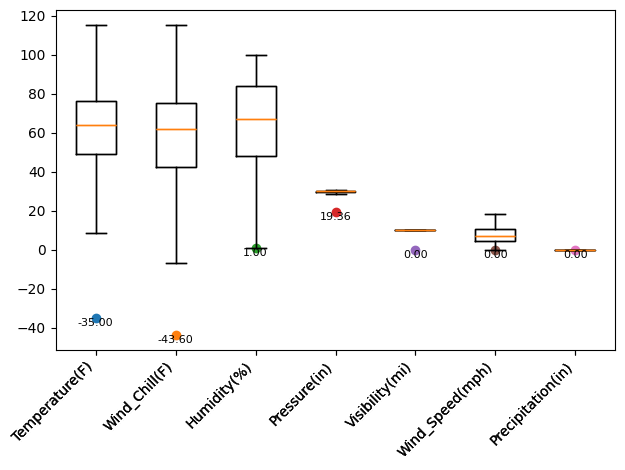

In [28]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

OUT = "hdfs://localhost:9900/data/us_accidents/cleaned_dedup_jsonl"  # your output folder

weather_cols = [
    "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)",
    "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"
]

# Read JSONL (Spark wrote part-* files)
df = spark.read.json(OUT)

# Keep only weather cols that exist
existing = [c for c in weather_cols if c in df.columns]
dfw = df.select([F.col(c).cast("double").alias(c) for c in existing])

# Sample to keep it light (adjust fraction if too few points)
pdf = dfw.sample(False, 0.01, seed=0).toPandas()   # ~1% sample

plt.figure()
plt.boxplot([pdf[c].dropna().values for c in existing], labels=existing, showfliers=False)
data = [pdf[c].dropna().values for c in existing]
bp = plt.boxplot(data, labels=existing, showfliers=False)

mins = [d.min() if len(d) else float("nan") for d in data]

# x positions are 1..N
for i, m in enumerate(mins, start=1):
    plt.scatter(i, m)              # point at min
    plt.text(i, m, f"{m:.2f}", va="top", ha="center", fontsize=8)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()